In [10]:
import requests
from tqdm import tqdm
import numpy as np

## Getting tokens

In [11]:
payload = {'grant_type':'password',
           'client_id':'083e9a44a763473fbeb62fbf90b74551',
           'client_secret':'ba09798f0921456e8b4e5e4588ea536d',
           'username':'tactioClinician',
           'password':'tactio'}

r = requests.post('https://sandbox86.tactiorpm7000.com/token.php',data=payload)

In [12]:
r.json()

{'access_token': 'ced745827f5ddf275de099e930ec282f7b71b516',
 'expires_in': '186282',
 'token_type': 'bearer',
 'scope': None,
 'refresh_token': '04d47954a7872a7485ee1e72bd4da984d970d01f',
 'role': '1',
 'roles': '["1"]',
 'aid': 'c4db45fa-181c-11e9-88bb-06ce0abb72be'}

## Get all patientIDs

In [13]:
headers = {'Authorization': 'Bearer '+'36682e009b195547dcdd2d461772e057bcd79b57'}
i=1
patientIDs=[]
while True:
    query = {'page':i}
    s = requests.get('https://sandbox86.tactiorpm7000.com/tactio-clinician-api/1.1.4/Patient',headers=headers,params=query)
    if 'entry' in s.json():
        patients = s.json()['entry']
        for patient in patients:
            patientIDs.append(patient['resource']['id'])
    else:
        break
    print('Finished page %s'%i)
    i += 1

print('There is a total of %s patients'%len(patientIDs))

Finished page 1
Finished page 2
Finished page 3
Finished page 4
Finished page 5
Finished page 6
Finished page 7
Finished page 8
Finished page 9
Finished page 10
Finished page 11
Finished page 12
Finished page 13
Finished page 14
Finished page 15
Finished page 16
Finished page 17
Finished page 18
Finished page 19
Finished page 20
Finished page 21
Finished page 22
Finished page 23
There is a total of 574 patients


In [16]:
import pickle
with open('patientIDs.pkl','wb') as f:
    pickle.dump(patientIDs,f)

In [17]:
patientData = {}

In [ ]:
for patientID in tqdm(patientIDs):
    query = {'subject': patientID}
    t = requests.get('https://sandbox86.tactiorpm7000.com/tactio-clinician-api/1.1.4/Observation',headers=headers,params=query)
    patientData[patientID] = {}
    if 'entry' in t.json():
        for obs in t.json()['entry']:
            #print(obs['resource']['code']['coding'])
            category = obs['resource']['code']['text']
            if category == 'pressure':
                sys = obs['resource']['component'][0]['valueQuantity']['value']
                dias = obs['resource']['component'][1]['valueQuantity']['value']
                if 'sys' in patientData[patientID]:
                    patientData[patientID]['sys'].append(sys)
                    patientData[patientID]['dias'].append(dias)
                else:
                    patientData[patientID]['sys'] = [sys]
                    patientData[patientID]['dias'] = [dias]
            else:
                try:
                    value = obs['resource']['valueQuantity']['value']
                except KeyError:
                    continue
                if category in patientData[patientID]:
                    patientData[patientID][category].append(value)
                else:
                    patientData[patientID][category] = [value]
    

In [ ]:
with open('patientIDs.pkl','wb') as f:
    pickle.dump(patientIDs,f)

## Explore data

In [22]:
import pickle

with open('dataset.pkl','rb') as f:
    patientData = pickle.load(f)

In [23]:
with open('patientIDs.pkl','rb') as f:
    patientIDs = pickle.load(f)

In [24]:
categories = []
for ID in patientIDs:
    keys = patientData[ID].keys()
    for key in keys:
        if not key in categories:
            categories.append(key)

In [25]:
categories

['height',
 'glucose',
 'glucose_post_meal',
 'cumulativeSleep',
 'fat_ratio',
 'steps',
 'weight',
 'bmi',
 'body_temperature',
 'waist',
 'pulse_rate',
 'mood',
 'sys',
 'dias',
 'blood_oxygen',
 'activityEnergy',
 'A1C']

In [26]:
common = categories
for ID in patientIDs:
    keys = patientData[ID].keys()
    if not len(keys) == 0:
        common = list(set(common) & set(keys))

In [30]:
common

['sys',
 'fat_ratio',
 'cumulativeSleep',
 'pulse_rate',
 'bmi',
 'body_temperature',
 'activityEnergy',
 'glucose',
 'glucose_post_meal',
 'blood_oxygen',
 'mood',
 'steps',
 'height',
 'waist',
 'dias',
 'weight']

In [8]:
lengths = []
for ID in patientIDs:
    temp = []
    for key in patientData[ID]:
        res = patientData[ID][key]
        temp.append(len(res))
    lengths.append(temp)

lengths

[[1, 57, 113, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 29],
 [1, 57, 113, 56, 56, 56, 57, 57, 56, 56, 56, 56, 56, 56, 56, 31],
 [1, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 114, 28],
 [1, 56, 56, 56, 56, 55, 55, 55, 56, 56, 55, 56, 56, 55, 110, 33],
 [1, 59, 117, 58, 58, 58, 58, 58, 59, 58, 59, 58, 58, 58, 58, 25],
 [1, 56, 111, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 32],
 [1, 58, 57, 58, 58, 58, 58, 58, 58, 58, 57, 57, 57, 57, 114, 27],
 [1, 57, 57, 57, 57, 56, 56, 56, 57, 57, 57, 56, 57, 56, 112, 30],
 [1, 58, 115, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 26],
 [1, 55, 109, 54, 54, 54, 54, 55, 55, 55, 55, 55, 54, 54, 55, 36],
 [1, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 115, 26],
 [1, 55, 55, 56, 56, 56, 55, 55, 55, 55, 55, 55, 56, 55, 110, 34],
 [1, 59, 117, 58, 58, 59, 58, 58, 58, 58, 59, 58, 58, 58, 58, 25],
 [1, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 115, 26],
 [1, 57, 58, 57, 57, 58, 58, 58, 57, 57, 57, 57, 57, 57, 114, 

In [9]:
clean_data = patientData
for ID in patientIDs:
    for key in clean_data[ID]:
        if key == 'body_temperature':
            arr = clean_data[ID][key]
            arr = [float(i) for i in arr]
            clean_data[ID][key] = max(arr)
        else:
            arr = clean_data[ID][key]
            arr = [float(i) for i in arr]
            clean_data[ID][key] = np.mean(arr)

In [35]:
clean_data[patientIDs[1]]

{'height': 1.75682,
 'glucose': 12.94707543859649,
 'glucose_post_meal': 8.220542300884956,
 'cumulativeSleep': 6.859126607142857,
 'mood': 3.682913035714286,
 'fat_ratio': 19.809228571428573,
 'bmi': 34.72626842105263,
 'blood_oxygen': 97.14592105263158,
 'pulse_rate': 96.54947321428571,
 'sys': 155.00439285714285,
 'dias': 94.07804464285714,
 'waist': 82.27843928571428,
 'weight': 107.16741071428571,
 'steps': 8269.830535714285,
 'body_temperature': 37.663,
 'activityEnergy': 70.3225806451613}

In [208]:
patientData[patientIDs[1]]

{'height': 1.75682,
 'glucose': 12.94707543859649,
 'glucose_post_meal': 8.220542300884956,
 'cumulativeSleep': 6.859126607142857,
 'mood': 3.682913035714286,
 'fat_ratio': 19.809228571428573,
 'bmi': 34.72626842105263,
 'blood_oxygen': 97.14592105263158,
 'pulse_rate': 96.54947321428571,
 'sys': 155.00439285714285,
 'dias': 94.07804464285714,
 'waist': 82.27843928571428,
 'weight': 107.16741071428571,
 'steps': 8269.830535714285,
 'body_temperature': 37.663,
 'activityEnergy': 70.3225806451613}

In [ ]:
#Get all features in lists

In [11]:
avg_data = {}
for ID in patientIDs:
    for key in common:
        if key in clean_data[ID]:
            if key in avg_data:
                avg_data[key].append(clean_data[ID][key])
            else:
                avg_data[key] = [clean_data[ID][key]]

In [12]:
features = avg_data.keys()
avg_arr = []
for key in features:
    avg_arr.append(avg_data[key])

In [13]:
np_avg = np.array(avg_arr)

In [14]:
np_avg.shape

(16, 567)

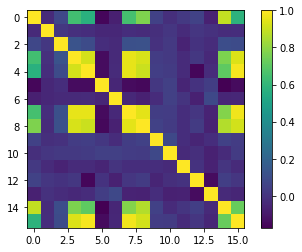

In [16]:
import numpy as np
import matplotlib.pyplot as plt

cm =np.corrcoef(np_avg)

plt.imshow(cm,interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
#Find number of people with certain conditions

In [18]:
#Infection
key = 'body_temperature'
key2 = 'dias'
key3 = 'fat_ratio'
key4 = 'waist'
subjects = []
for ID in patientIDs:
    if key in clean_data[ID]:
        entry = clean_data[ID]
        if entry[key] > 37.7:
            subjects.append(ID)

NameError: name 'clean_data' is not defined

In [276]:
len(subjects)

61

In [102]:
#Find averages

In [52]:
def margin(x_bar, mean, sigma):
    upper = mean + sigma
    lower = mean - sigma
    
    if  lower <= x_bar <= upper:
        return True

In [36]:
key = 'sys'

np.mean(avg_data[key])

122.07782667307906

In [ ]:
key = 'body_temperature'
data = []
for ID in subjects:
    if key in clean_data[ID]:
        data.append(clean_data[ID][key])

np.mean(data)

In [81]:
clean_data[subjects[19]]

{'height': 1.76785,
 'steps': 8599.55245614035,
 'blood_oxygen': 96.9731649122807,
 'pulse_rate': 96.90226140350877,
 'body_temperature': 36.931057894736846,
 'weight': 108.46294642857143,
 'waist': 83.39299107142858,
 'cumulativeSleep': 6.959291578947369,
 'fat_ratio': 19.49833421052632,
 'mood': 3.750731403508772,
 'sys': 142.50673214285715,
 'dias': 100.35605535714286,
 'bmi': 34.69976842105263,
 'glucose': 12.755975000000001,
 'glucose_post_meal': 7.855470535714285,
 'activityEnergy': 71.33333333333333}

In [45]:
# OBESITY

In [ ]:
key = 'bmi'
obesityIDs = []
for ID in patientIDs:
    if key in clean_data[ID]:
        if clean_data[ID][key] > 30.0:
            obesityIDs.append(ID)
obesityIDs

['0029a7f9-fd73-4629-9a2f-3170c0338420',
 '011611bb-cb81-437c-ab2c-14c8ee1dd819',
 '0923b2b9-b076-4b7c-aea2-5fe76e259035',
 '0a2274ed-dda2-4f37-ba8d-7b1ccb28f37c',
 '0b66fe33-2924-4802-8bd8-e0daf19f0f13',
 '0c190312-214b-4bb5-9e8c-53bebb9af853',
 '0c659112-2aa9-4033-85f2-ec1792b783f5',
 '0f89bcab-0c58-4d4f-983e-d703fd392c3d',
 '18c15185-fb76-43a0-b19a-cbf821108289',
 '1ab36730-46ca-4371-8b18-77eed7adfcb2',
 '1c6e552d-7c93-4dbb-999f-323588914ef6',
 '1cb36563-fe65-4d33-aebf-17662139400d',
 '262b3073-b3ed-449b-a593-798a4b1d554e',
 '27a1f01d-528b-4548-933c-3c87b24ba224',
 '2961d31a-80ce-4522-84e8-366ee1cc826e',
 '297d92d7-0eff-4677-bfd1-abc1b8ad5140',
 '2a4f21d6-ff00-4f6c-8fed-2fcf2cdadfb0',
 '3171402d-9e28-40c2-9b2d-0ab8647d3291',
 '327c82fd-f742-49f7-843a-90f14ee4a4d8',
 '3543de00-7868-4cef-9a9d-115b6be71a7b',
 '38f2d480-9a88-4774-a25c-89b2501aefe6',
 '3a8f40da-a97f-4d81-b3cb-f72b255eeb6b',
 '3d816c1a-fde7-43a1-8729-ba5b15e0b84a',
 '41fdbf54-244c-48d4-beb4-f673b5571dff',
 '4b757e15-d038-

In [ ]:
                              #Blood Fat

In [19]:
key = 'sys'
key2 = 'dias'
key3 = 'fat_ratio'
key4 = 'waist'
BFIDs = []
for ID in patientIDs:
    if key in clean_data[ID]:
        entry = clean_data[ID]
        if entry[key] > 140 and entry[key2] > 90 and entry[key4] > 88:
            BFIDs.append(ID)
            
BFIDs

['0923b2b9-b076-4b7c-aea2-5fe76e259035',
 '0bd3fb14-d2f4-47ed-be02-3d41beba2ee7',
 '18c15185-fb76-43a0-b19a-cbf821108289',
 '58f47f58-7698-4bb4-a041-289551d35e78',
 '660d60eb-15ff-412e-9f9c-93f613fde3b3',
 '6f92a50b-9109-41c8-affd-32e06c5aeea1',
 '936703a3-611d-4b13-a221-938ec821899a',
 'c8c347e6-b01a-48bd-91ee-668660d3e029',
 'dbbd0304-ef1f-417a-8d9c-2b9079ffeef3',
 'e2ec862e-0bd4-4d4b-84dc-35e237eb4f7d',
 'effe0c11-95cf-4c40-9b8e-037fb4c2489a']

In [53]:
#Diabeties and hypertension
key = 'sys'
key2 = 'dias'
key3 = 'glucose'
key4 = 'glucose_post_meal'
key5 = 'A1C'
key6 = "glucose_bedtime" #check name
key7 = "pulse_rate"

DHIDs = []
for ID in patientIDs:
    if key in clean_data[ID]:
        entry = clean_data[ID]
        if margin(entry[key], 175, 10) and margin(entry[key2], 115, 10) and margin(entry[key3], 5.5, 0.6) and margin(entry[key4], 6.9, 0.9) and margin(entry[key7], 70, 10): #missing bed, A1C
            DHIDs.append(ID)

DHIDs

['1f771da3-ab67-4576-8484-8000d5259554',
 '9cf0a3b4-43d3-4b2f-b0ab-ee0b2e35a3de',
 'd948c9c2-9122-4520-80a4-b3d30906c35d']

In [173]:
len(obesityIDs)

84

In [ ]:
#Means

In [248]:
mean_data = {}
for key in avg_data:
    mean_data[key] = np.mean(avg_data[key])

In [249]:
mean_data

{'glucose_post_meal': 6.272263498094864,
 'weight': 76.4975285201567,
 'fat_ratio': 19.92837168475372,
 'dias': 75.17150322954214,
 'glucose': 5.771027873748133,
 'cumulativeSleep': 7.023141258994901,
 'pulse_rate': 69.4279045834592,
 'blood_oxygen': 97.0000766456821,
 'height': 1.7498063844797178,
 'waist': 83.97820611736724,
 'steps': 9006.746938674896,
 'mood': 3.7229431883640567,
 'sys': 122.07782667307906,
 'body_temperature': 37.56360035273369,
 'bmi': 25.0055726798476,
 'activityEnergy': 74.77221724229662}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
y = [float(i) for i in patientData[patientIDs[0]]['cumulativeSleep']]
x = list(range(len(x)))

In [ ]:
plt.scatter(x,y)
plt.show()